In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)
data_dir=pathlib.Path(data_dir)

In [3]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


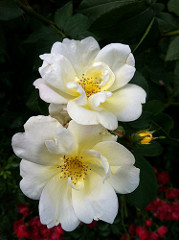

In [4]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

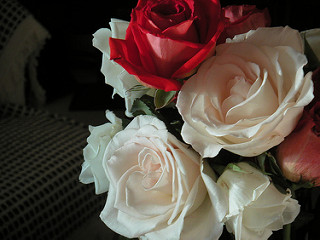

In [5]:
PIL.Image.open(str(roses[1]))

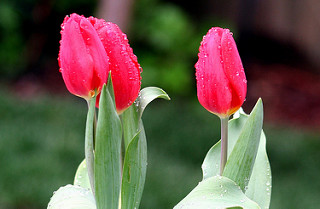

In [6]:
tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

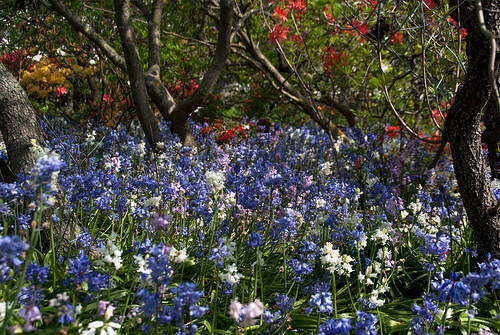

In [7]:
PIL.Image.open(str(tulips[1]))

In [8]:
batch_size=32
img_height=180
img_width=180

In [9]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


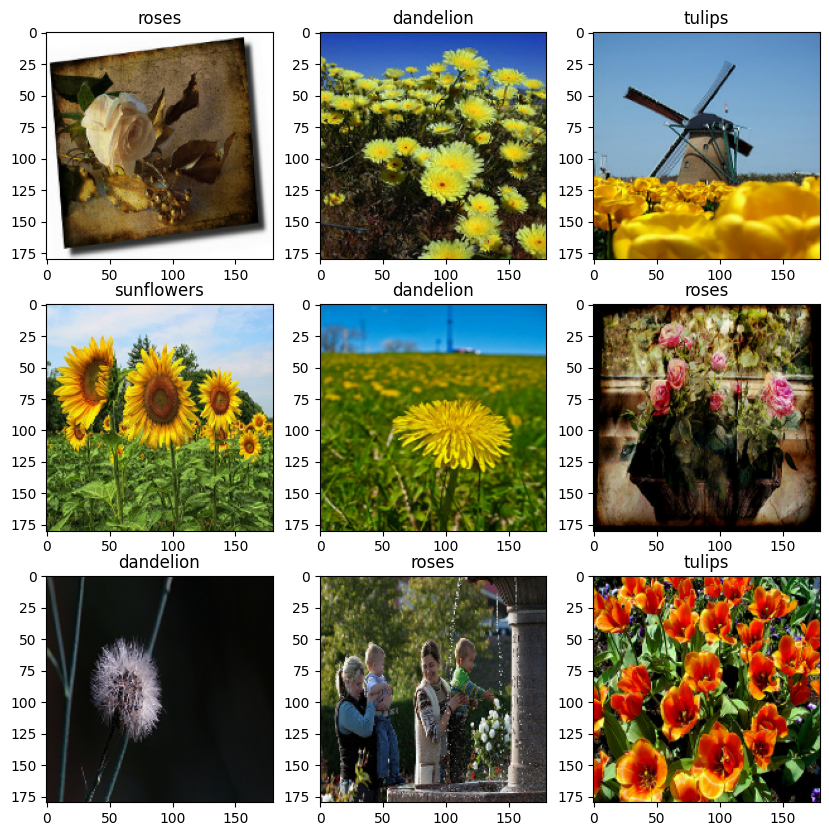

In [12]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer=layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
#Notice the pixel values are now in '[0,1]'.
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [17]:
num_classes=len(class_names)

model=Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
histroy=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 240s 3s/step - loss: 1.3113 - accuracy: 0.4319 - val_loss: 1.0444 - val_accuracy: 0.5599
Epoch 2/10
92/92 [==============================] - 205s 2s/step - loss: 0.9928 - accuracy: 0.6083 - val_loss: 0.9511 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 190s 2s/step - loss: 0.8126 - accuracy: 0.6832 - val_loss: 0.9485 - val_accuracy: 0.5858
Epoch 4/10
92/92 [==============================] - 220s 2s/step - loss: 0.5878 - accuracy: 0.7759 - val_loss: 0.9410 - val_accuracy: 0.6553
Epoch 5/10
92/92 [==============================] - 198s 2s/step - loss: 0.3972 - accuracy: 0.8505 - val_loss: 0.9628 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 189s 2s/step - loss: 0.2594 - accuracy: 0.9104 - val_loss: 1.2769 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 190s 2s/step - loss: 0.1459 - accuracy: 0.9574 - val_loss: 1.5246 - val_accuracy: 0.6049
Epoch 8/10
92

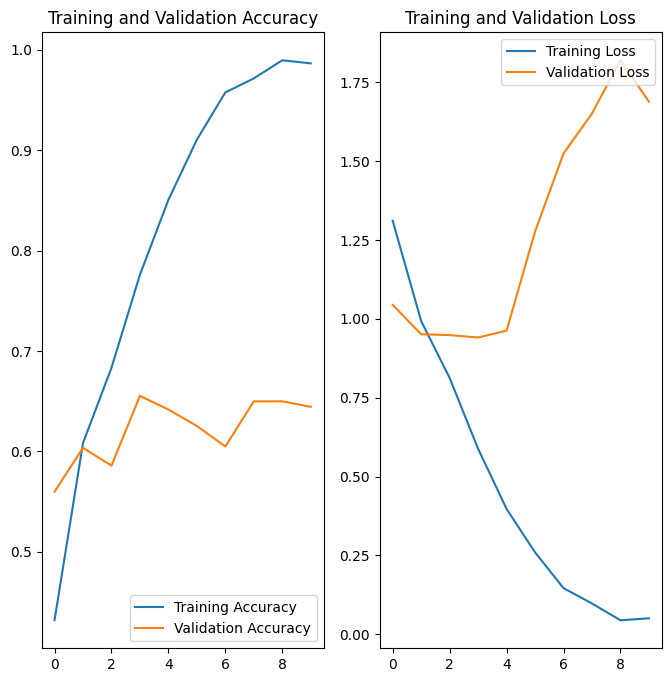

In [21]:
acc = histroy.history['accuracy']
val_acc = histroy.history['val_accuracy']

loss = histroy.history['loss']
val_loss = histroy.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation=keras.Sequential(
    [
            layers.RandomFlip("horizontal",
                              input_shape=(img_height,
                                          img_width,
                                           3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

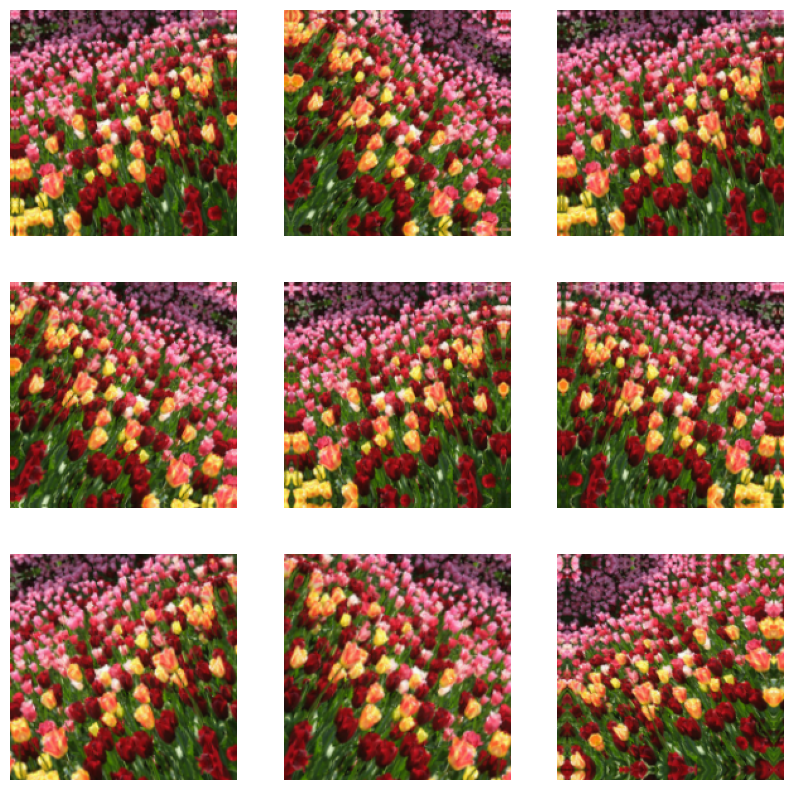

In [23]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
model=Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [26]:
#model.build()

In [27]:
epochs=15
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 229s 2s/step - loss: 1.2659 - accuracy: 0.4622 - val_loss: 1.0403 - val_accuracy: 0.5409
Epoch 2/15
92/92 [==============================] - 203s 2s/step - loss: 1.0027 - accuracy: 0.5964 - val_loss: 1.0108 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 202s 2s/step - loss: 0.8555 - accuracy: 0.6761 - val_loss: 0.9538 - val_accuracy: 0.6322
Epoch 4/15
92/92 [==============================] - 206s 2s/step - loss: 0.7145 - accuracy: 0.7302 - val_loss: 0.8939 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 207s 2s/step - loss: 0.5379 - accuracy: 0.8035 - val_loss: 0.9952 - val_accuracy: 0.6444
Epoch 6/15
92/92 [==============================] - 207s 2s/step - loss: 0.3881 - accuracy: 0.8617 - val_loss: 0.9796 - val_accuracy: 0.6676
Epoch 7/15
92/92 [==============================] - 204s 2s/step - loss: 0.2519 - accuracy: 0.9149 - val_loss: 0.9357 - val_accuracy: 0.6826
Epoch 8/15
92

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
sunflower_url="https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path=tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img=tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height,img_width)
)
img_array=tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array, 0)#Create a batch

predictions=model.predict(img_array)
score=tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.
